In [2]:
!pip install torch-lr-finder

In [3]:
!pip install split-folders

In [8]:
import os
import torch
import pandas as pd
import random
import seaborn as sns
from PIL import Image


from torch.utils.data import WeightedRandomSampler
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

import splitfolders
import torch.optim as optim 
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

E:\Anaconda\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
data_dir = r'E:\Jupyter\Samples\FSamples'

In [10]:
class_labels = ['Cercospora', 'Healthy', 'Leaf Blight', 'Leaf Rust', 'Lichens', 'Sooty Mold', 'Wilt']

In [11]:
def pad_image(image):
    # Get the dimensions of the image
    width, height = image.size

    # Find the longer side
    max_dim = max(width, height)

    # Create a square background image
    background = Image.new('RGB', (max_dim, max_dim), (255, 255, 255))

    # Calculate the position to paste the original image on the background
    pos = ((max_dim - width) // 2, (max_dim - height) // 2)

    # Paste the original image on the background
    background.paste(image, pos)

    return background

In [12]:
# Image pre-process/Image augmentation
data_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.CenterCrop(448),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [13]:
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0]*len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        img = pad_image(img)
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)


In [14]:
dataset = CoffeeDataset(data_dir, transform=data_transforms)

In [15]:
splitfolders.ratio("E:\Jupyter\Samples\FSamples",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 1358 files [00:10, 125.65 files/s]


In [16]:
train = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/train",
                              transform=data_transforms)

val = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/val",
                              transform=data_transforms)

test = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/test",
                              transform=data_transforms)

# -------- Getting the Whole Dataset for Visualization Purposes --------
data = datasets.ImageFolder(root="E:\Jupyter\Samples\FSamples",
                              transform=data_transforms)

In [17]:
print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'Cercospora': 0, 'Healthy': 1, 'Leaf Blight': 2, 'Leaf Rust': 3, 'Lichens': 4, 'Sooty Mold': 5, 'Wilt': 6} 

Images per Class in TRAIN:
0    320
3    240
4    127
5     91
6     74
1     58
2     37
Name: count, dtype: int64 

Images per Class in VALIDATION:
0    91
3    68
4    36
5    26
6    21
1    16
2    10
Name: count, dtype: int64 

Images per Class in TEST:
0    47
3    36
4    19
5    13
6    11
1    10
2     7
Name: count, dtype: int64 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

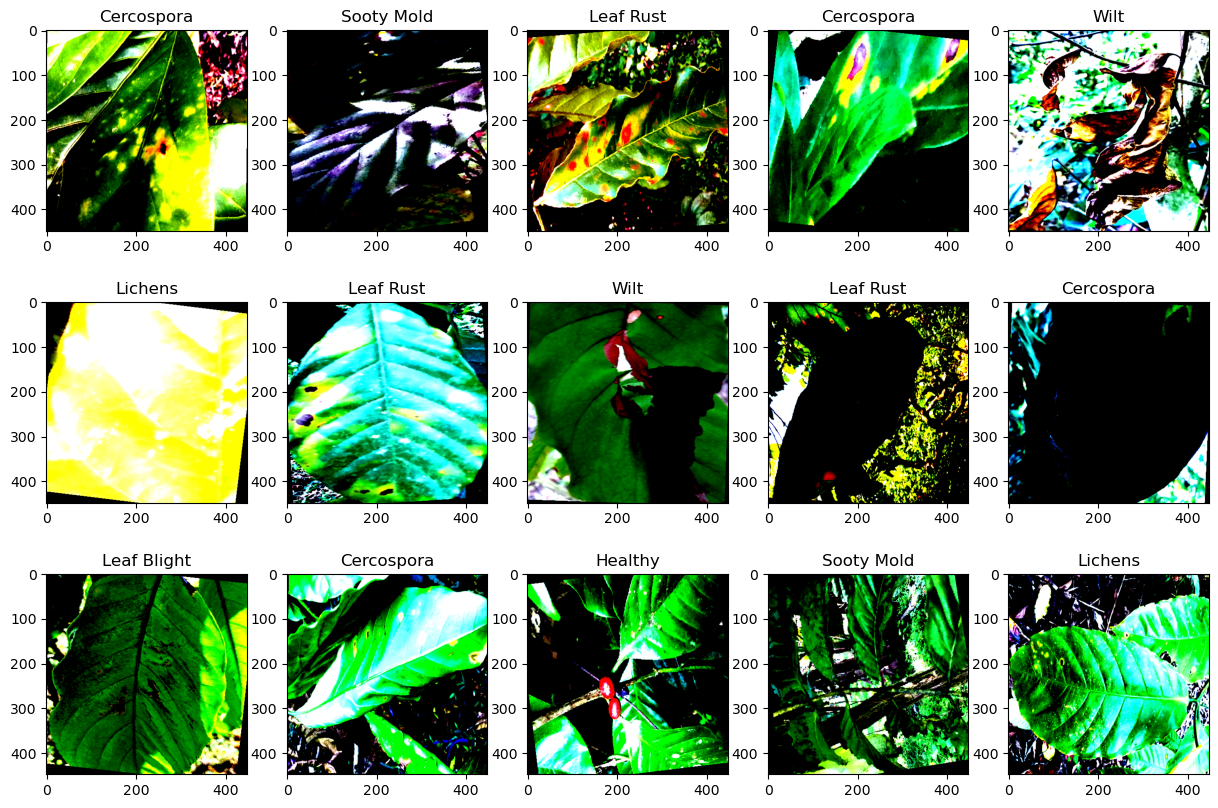

In [18]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data) - 1)
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

In [19]:
train_loader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_loader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_loader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

In [20]:
print("Length of training dataset:", len(train))
print("Length of validation dataset:", len(val))
print("Length of test dataset:", len(test))

Length of training dataset: 947
Length of validation dataset: 268
Length of test dataset: 143


In [21]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\Nicko/.cache\torch\hub\pytorch_vision_v0.10.0
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [23]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels) 
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [24]:
# Create the CNN model
model = resnet

In [25]:
# Check for available GPUs
device = torch.device("cuda")

In [26]:
# Move the model to the GPU
model = model.to("cuda")

In [27]:
# Get the total number of samples and the number of samples per class
total_samples = 0
samples_per_class = []
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        num_samples = len(os.listdir(class_dir))
        total_samples += num_samples
        samples_per_class.append(num_samples)
        print(f"Number of images in {label}: {num_samples}")

# Calculate the class weights
class_weights = [total_samples / x for x in samples_per_class]
weights = torch.tensor(class_weights).to("cuda")

criterion = nn.BCEWithLogitsLoss(pos_weight=weights.cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001)


Number of images in Cercospora: 458
Number of images in Healthy: 84
Number of images in Leaf Blight: 54
Number of images in Leaf Rust: 344
Number of images in Lichens: 182
Number of images in Sooty Mold: 130
Number of images in Wilt: 106


In [28]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

E:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [29]:
def train_model(model, criterion, optimizer, num_epochs=64, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists for saving history
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # Early stopping details
    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False  # Flag to indicate if early stopping occurred

    for epoch in range(num_epochs):
        if early_stop:  # Check if early stopping occurred
            print('Breaking out of epoch loop due to early stopping.')
            break  # Break out of the epoch loop

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {lr}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.cuda()
                labels = labels.cuda().long()

                # Add an extra dimension to labels
                labels = torch.nn.functional.one_hot(labels, num_classes=7).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate the number of correct predictions
                preds = outputs > 0.5
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / (len(data_loader.dataset) * num_classes)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            # Check if early stopping conditions are met
            if phase == 'val':
                scheduler.step(epoch_loss)  
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True  # Set the early stopping flag
                        break  # Break out of the phase loop

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(model, criterion, optimizer, num_epochs=64, patience=5)

torch.save(model.state_dict(), 'model.pth')

print("Training finished...\n")


Epoch 1/64
----------
Learning Rate: 0.001
train Loss: 1.2323 Acc: 0.7464
val Loss: 1.0591 Acc: 0.8081
Epoch 2/64
----------
Learning Rate: 0.001
train Loss: 0.9965 Acc: 0.8229
val Loss: 0.8951 Acc: 0.8571
Epoch 3/64
----------
Learning Rate: 0.001
train Loss: 0.8728 Acc: 0.8392
val Loss: 0.8405 Acc: 0.8566
Epoch 4/64
----------
Learning Rate: 0.001
train Loss: 0.8066 Acc: 0.8445
val Loss: 0.7890 Acc: 0.8198
Epoch 5/64
----------
Learning Rate: 0.001
train Loss: 0.7298 Acc: 0.8611
val Loss: 0.7667 Acc: 0.8459
Epoch 6/64
----------
Learning Rate: 0.001
train Loss: 0.7121 Acc: 0.8544
val Loss: 0.7663 Acc: 0.8316
Epoch 7/64
----------
Learning Rate: 0.001
train Loss: 0.6689 Acc: 0.8663
val Loss: 0.7097 Acc: 0.8268
Epoch 8/64
----------
Learning Rate: 0.001
train Loss: 0.6622 Acc: 0.8623
val Loss: 0.6907 Acc: 0.8657
Epoch 9/64
----------
Learning Rate: 0.001
train Loss: 0.6696 Acc: 0.8583
val Loss: 0.6578 Acc: 0.8465
Epoch 10/64
----------
Learning Rate: 0.001
train Loss: 0.6358 Acc: 0.854

In [45]:
import sklearn
print(sklearn.__version__)


1.4.2


In [54]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report

def test_model(model, test_loader, device, class_labels):
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Individual models
    models = [
        ('svm', SVC()),
        ('knn', KNeighborsClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
    ]

    for name, model in models:
        model.fit(all_predictions.reshape(-1, 1), all_labels)
        preds = model.predict(all_predictions.reshape(-1, 1))
        print(f"{name.upper()} Classification Report:")
        print(classification_report(all_labels, preds, target_names=class_labels, zero_division=1))

    # Voting Classifier
    voting_model = VotingClassifier(estimators=models, voting='hard')
    voting_model.fit(all_predictions.reshape(-1, 1), all_labels)
    voting_preds = voting_model.predict(all_predictions.reshape(-1, 1))
    print("Voting Classifier Classification Report:")
    print(classification_report(all_labels, voting_preds, target_names=class_labels, zero_division=1))

# Call the function to test the models
test_model(model, test_loader, device, class_labels)


SVM Classification Report:
              precision    recall  f1-score   support

  Cercospora       0.53      0.83      0.65        47
     Healthy       0.82      0.90      0.86        10
 Leaf Blight       0.67      0.86      0.75         7
   Leaf Rust       1.00      0.00      0.00        36
     Lichens       0.71      0.79      0.75        19
  Sooty Mold       0.56      0.77      0.65        13
        Wilt       1.00      1.00      1.00        11

    accuracy                           0.63       143
   macro avg       0.76      0.74      0.66       143
weighted avg       0.74      0.63      0.55       143

KNN Classification Report:
              precision    recall  f1-score   support

  Cercospora       0.41      0.98      0.58        47
     Healthy       0.82      0.90      0.86        10
 Leaf Blight       0.67      0.86      0.75         7
   Leaf Rust       1.00      0.00      0.00        36
     Lichens       1.00      0.00      0.00        19
  Sooty Mold       1.00 

In [43]:
def test_model():
    model = models.resnet50(weights = None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 7)

    model = model.to(device)
    model.load_state_dict(torch.load("model.pth"))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    print("Test Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_labels))

    # Return a flattened array of all predictions
    return np.array(all_predictions).flatten()

# Call the function to test the model
all_preds = test_model()


Test Classification Report:
              precision    recall  f1-score   support

  Cercospora       0.60      0.53      0.56        47
     Healthy       0.82      0.90      0.86        10
 Leaf Blight       0.67      0.86      0.75         7
   Leaf Rust       0.47      0.44      0.46        36
     Lichens       0.70      0.74      0.72        19
  Sooty Mold       0.69      0.85      0.76        13
        Wilt       1.00      1.00      1.00        11

    accuracy                           0.64       143
   macro avg       0.71      0.76      0.73       143
weighted avg       0.64      0.64      0.64       143



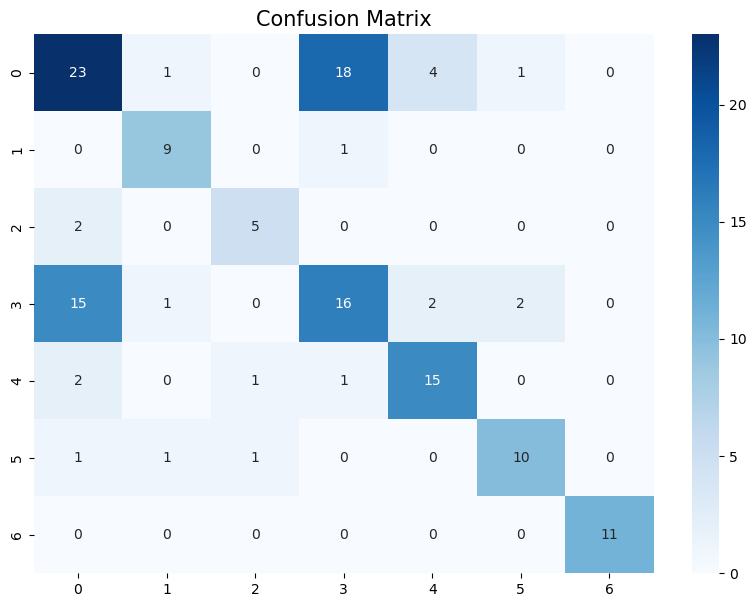

In [33]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

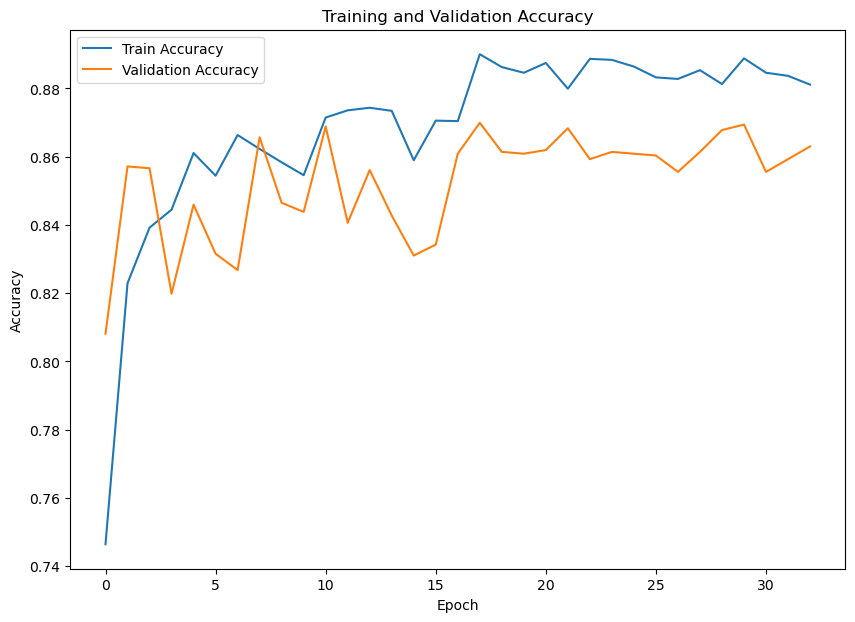

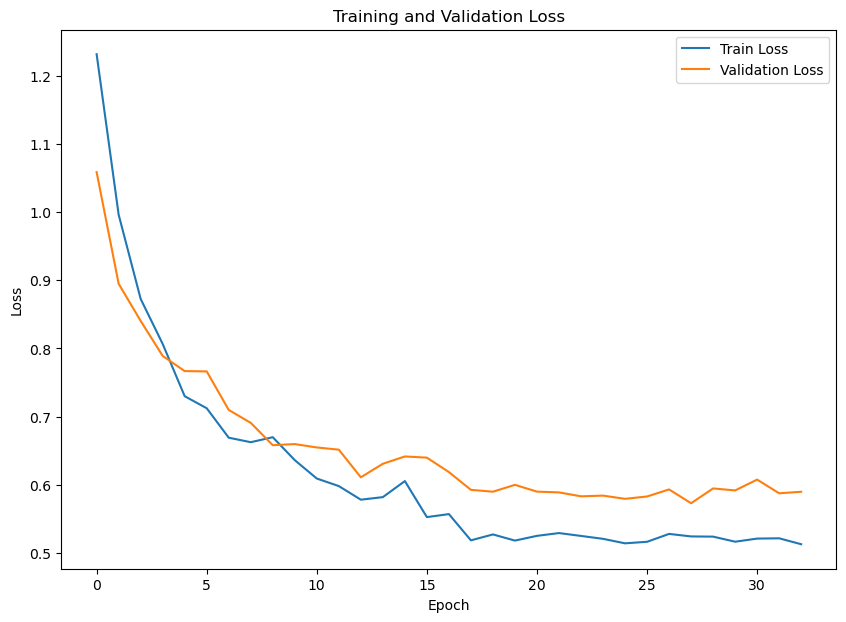

Best val Loss: 0.5726
Best val Acc: 0.8699


In [34]:
def plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc):
    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print training time and best metrics
    print(f'Best val Loss: {best_loss:.4f}')
    print(f'Best val Acc: {best_acc:.4f}')

plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


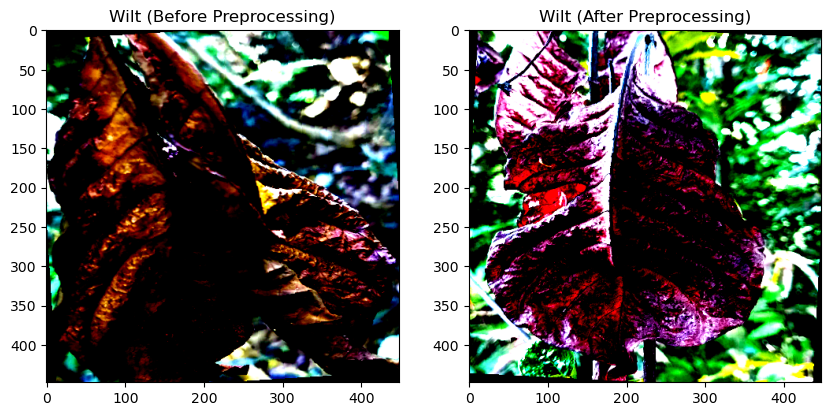

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In [41]:
# Initialize the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(class_labels) 
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved parameters
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
# Don't forget to set the model to evaluation mode if you're doing inference
model.eval()

# Define the prediction function
def predict_image(image_path, model, threshold=0.6):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        # Get the probabilities from the outputs
        probs = torch.sigmoid(output)
        # Apply a threshold
        preds = probs > threshold
        # Get the indices of the positive predictions
        positive_indices = [i for i, x in enumerate(preds[0]) if x]
        # Return the corresponding class labels
        return [class_labels[i] for i in positive_indices]

# Use the prediction function
image_path = "E:\Jupyter\ML\ValidationSamples\CP (27).jpg"  
print("Predicted Class: ", predict_image(image_path, model))

Predicted Class:  ['Cercospora']
